In [1]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.7 MB/s eta 0:00:00


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chrisfilo/urbansound8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/urbansound8k


In [3]:
import librosa
audio_file_path='/kaggle/input/urbansound8k/fold10/100648-1-0-0.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

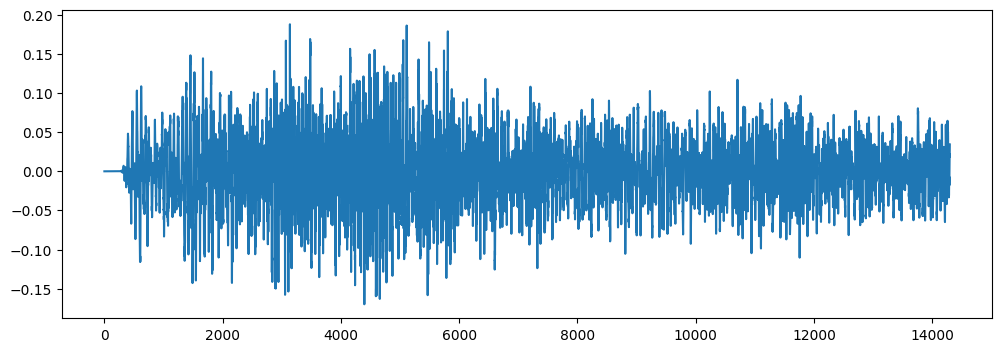

In [4]:
import matplotlib.pyplot as plt
# Original audio with 1 channel
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

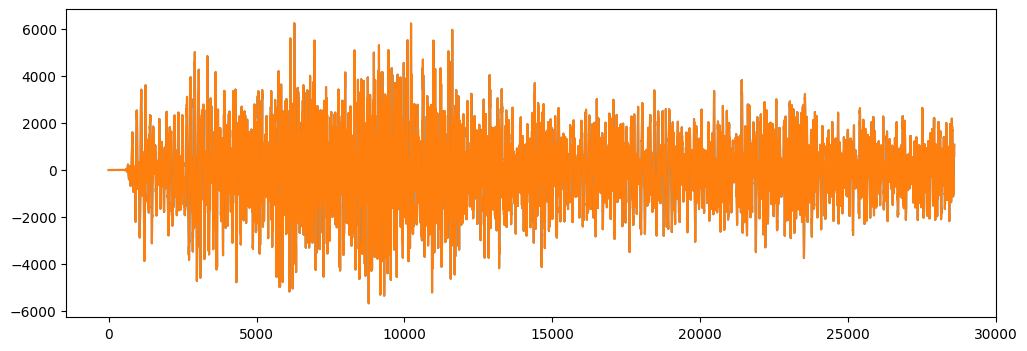

In [5]:
### Lets read with scipy
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt

# Original audio with 2 channels
wave_sample_rate, wave_audio = wav.read(audio_file_path)
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

In [9]:
wave_audio

array([[   0,    0],
       [   0,    0],
       [   0,    0],
       ...,
       [1043, 1043],
       [1026, 1026],
       [1073, 1073]], dtype=int16)

Here Librosa converts the signal to mono, meaning the channel will always be 1 channel

###Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [6]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 28)


In [11]:
mfccs

array([[-3.50337921e+02, -2.36006485e+02, -1.99549072e+02, ...,
        -1.96953873e+02, -2.00550217e+02, -2.06404999e+02],
       [ 1.30763702e+02,  1.23476776e+02,  1.16075684e+02, ...,
         1.03111771e+02,  9.58280334e+01,  1.01292206e+02],
       [ 4.07228661e+00,  9.29231548e+00,  2.58745408e+00, ...,
        -5.87990570e+00, -1.78672791e-01,  5.56627274e-01],
       ...,
       [-6.21877193e+00, -4.94141674e+00,  7.25934863e-01, ...,
         1.50536478e+00, -3.53703141e+00, -1.86897862e+00],
       [ 8.20162201e+00,  1.56167209e+00, -4.18310261e+00, ...,
        -2.91616750e+00, -7.82347262e-01,  3.90978098e-01],
       [-8.63108635e+00, -2.89507532e+00, -3.83393240e+00, ...,
        -2.25498223e+00,  2.39101410e+00,  3.70792985e+00]], dtype=float32)

In [7]:
#### Extracting MFCC's For every audio file
import pandas as pd
import os
import librosa

audio_dataset_path='/kaggle/input/urbansound8k/'
metadata=pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [8]:
import resampy

In [9]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features


In [10]:
import resampy
import numpy as np
from tqdm import tqdm #tqdm lib just to see the progress
### Now we iterate through every audio file and extract features
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3554it [06:55, 10.39it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8324it [15:20, 14.17it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
8328it [15:20, 19.17it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [16:00,  9.09it/s]


In [11]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22339, -130.38528, -53.282906,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.7912, 121.38421, -46.520657, 52.00812, -...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036358, ...",children_playing
4,"[-446.60355, 113.685425, -52.402214, 60.302044...",children_playing


In [12]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [13]:
print(X.shape)
print(y)

(8732, 40)
['dog_bark' 'children_playing' 'children_playing' ... 'car_horn'
 'car_horn' 'car_horn']


In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [16]:
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")


X_train.shape: (6985, 40)
X_test.shape: (1747, 40)
y_train.shape: (6985, 10)
y_test.shape: (1747, 10)


##Model Creation


In [17]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.5 MB/s eta 0:00:00


In [18]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import metrics
import keras_tuner as kt

In [44]:
callback = EarlyStopping(monitor='val_accuracy',
                           patience=20,
                           restore_best_weights=True)

In [45]:
def build_model(hp):
  model = Sequential()

  counter = 0
  #We used in if condn to create input layer


  for i in range(hp.Int('num_layers',min_value=1,max_value=10)):

    if counter == 0:
      model.add(Dense(
          hp.Int('units' + str(i),min_value=8,max_value=128,step=8),
          activation= hp.Choice('activation'+ str(i), values=['relu','tanh','sigmoid']),
          input_dim=40 ))
      model.add(Dropout(hp.Choice('dropout'+str(i), values=[0.1,0.2,0.4,0.5,0.6,0.7,0.8,0.9])))

    else:
      model.add(Dense(
          hp.Int('units' + str(i),min_value=8,max_value=128,step=8),
          activation= hp.Choice('activation'+ str(i), values=['relu','tanh','sigmoid'])))
      model.add(Dropout(hp.Choice('dropout'+str(i), values=[0.1,0.2,0.4,0.5,0.6,0.7,0.8,0.9])))
    counter += 1

  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer=hp.Choice('optimizer',['adam','rmsprop']),
                loss='categorical_crossentropy', metrics=['accuracy']) # Changed loss function

  return model

In [46]:
tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=10,
                        directory='mydir6')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[callback] )


Trial 10 Complete [00h 00m 32s]
val_accuracy: 0.10475099831819534

Best val_accuracy So Far: 0.589009702205658
Total elapsed time: 00h 09m 11s


In [48]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 3,
 'units0': 80,
 'activation0': 'sigmoid',
 'dropout0': 0.7,
 'optimizer': 'rmsprop',
 'units1': 8,
 'activation1': 'relu',
 'dropout1': 0.1,
 'units2': 8,
 'activation2': 'relu',
 'dropout2': 0.1}

In [49]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,090 (15.98 KB)

 Trainable params: 4,090 (15.98 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
histoty = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), initial_epoch=50, callbacks=[callback])

Epoch 51/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4511 - loss: 1.5591 - val_accuracy: 0.5821 - val_loss: 1.3297
Epoch 52/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4425 - loss: 1.5513 - val_accuracy: 0.5758 - val_loss: 1.3142
Epoch 53/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4522 - loss: 1.5701 - val_accuracy: 0.5736 - val_loss: 1.3186
Epoch 54/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4573 - loss: 1.5490 - val_accuracy: 0.5810 - val_loss: 1.3182
Epoch 55/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4730 - loss: 1.5127 - val_accuracy: 0.5844 - val_loss: 1.3097
Epoch 56/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4697 - loss: 1.5227 - val_accuracy: 0.5867 - val_loss: 1.3071
Epoch 57/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4616 - loss: 1.5426 - val_accuracy: 0.5902 - val_loss: 1.3014
Epoch 58/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4540 - loss: 

In [58]:
model2=Sequential()
###first layer
model2.add(Dense(500,input_shape=(40,)))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
###second layer
model2.add(Dense(250))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
# ###third layer
# model2.add(Dense(200))
# model2.add(Activation('relu'))
# model2.add(Dropout(0.5))
# ###4th layer
# model2.add(Dense(100))
# model2.add(Activation('relu'))
# model2.add(Dropout(0.5))

###final layer
model2.add(Dense(10))
model2.add(Activation('softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
model2.compile(optimizer='adam',
                loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
histoty2 = model2.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2488 - loss: 7.3873 - val_accuracy: 0.4602 - val_loss: 1.6425
Epoch 2/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4260 - loss: 1.6628 - val_accuracy: 0.5610 - val_loss: 1.3094
Epoch 3/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5042 - loss: 1.4147 - val_accuracy: 0.6417 - val_loss: 1.1074
Epoch 4/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5756 - loss: 1.2344 - val_accuracy: 0.6800 - val_loss: 0.9866
Epoch 5/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6311 - loss: 1.0605 - val_accuracy: 0.7212 - val_loss: 0.8530
Epoch 6/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6732 - loss: 0.9644 - val_accuracy: 0.7355 - val_loss: 0.8002
Epoch 7/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7079 - loss: 0.8527 - val_accuracy: 0.7613 - val_loss: 0.7260
Epoch 8/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7337 - loss: 0.7913 -

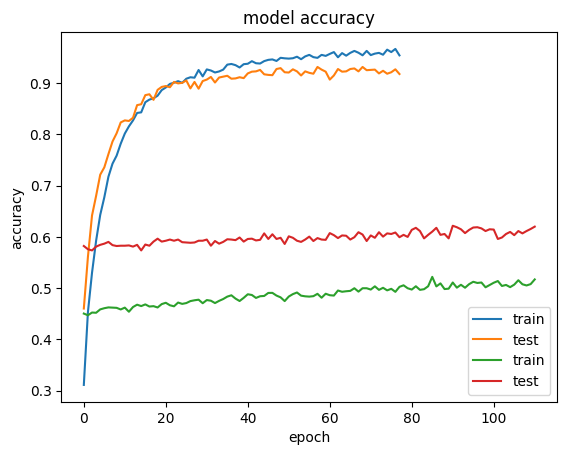

In [62]:
plt.plot(histoty2.history['accuracy'])
plt.plot(histoty2.history['val_accuracy'])
plt.plot(histoty.history['accuracy'])
plt.plot(histoty.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test','train', 'test'], loc='lower right')
plt.show()

In [63]:
model2.evaluate(X_test,y_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9204 - loss: 0.3147


[0.28171631693840027, 0.9313108325004578]

In [65]:
model2.save('model.keras')